<a href="https://colab.research.google.com/github/jolurf/Computer-Vision/blob/main/Classical_CV/segmentation_for_students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP 2 : Computer Vision

## Part 1 : segmentation

In this part of the TP, we are going to implement two approaches to image segmentation :

- algorithm of Otsu (histogram-based segmentation)
- a simple region-growing based algorithm

First, let us load some packages and define some helper functions (as in the previous TP)

(800, 586)

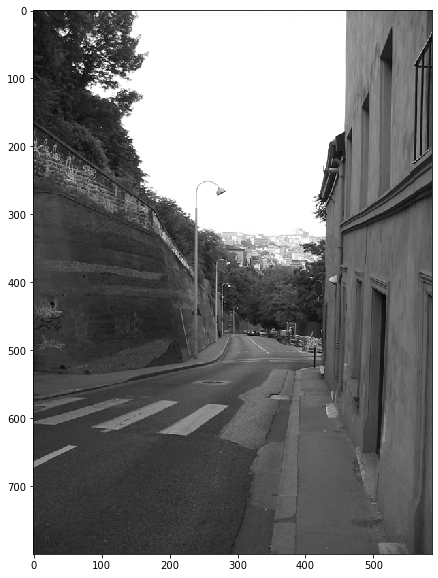

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import imageio
from skimage import color

def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color

def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))

def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

file_dir = 'images/'
file_name = 'crossing'
file_ext = '.png'

is_colab = False

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/crossing.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)

display_image(img_gray)
img_size = img_gray.shape
img_size

## Otsu's algorithm

Otsu's method is based on finding a threshold to split the image into two separate segments, based simply on their grey-level values. Since the maximum number of grey-levels is finite (and small, 256), we can use an exhaustive search.

The grey-level threshold is the one that minimises the following criterion :

$argmin_{\tau} \omega_0(\tau)\sigma_0(\tau) + \omega_1(\tau)\sigma_1(t)$

where

- $\sigma_0(\tau)$ and $\sigma_1(\tau)$ are the variances of the pixels in the first and second regions
- $\omega_0(\tau)$ and $\omega_1(\tau)$ are weights of the first and second regions

and

- $\omega_0(\tau) = \sum_{p \in \Omega} \mathbb{1}_{\tau}(I(p)), \qquad$
- $\omega_1(\tau) = \sum_{p \in \Omega} 1-\mathbb{1}_{\tau}(I(p))$

and

$\mathbb{1}_{\tau}(I(p)) =\begin{cases}
        1 \; \text{if} \: I(p)<=\tau\\
        0 \; \text{otherwise}
\end{cases}$

Implement this algorithm in a function called ``segmentation_otsu``. Note : only analyse thresholds which produce two distinct regions : you cannot have a region with no pixels. Furthemore, remember that the image is normalised between 0 and 1, with 256 discrete values. Choose the threshold values accordingly.

In [ ]:
# This function returns the segmentation of the algorithm of otsu, as well as the threshold found
def segmentation_otsu(img):
    hist_vals, hist_edges = np.histogram(img, bins=np.linspace(0,1,257))
    tau_pixel = np.cumsum(hist_vals)/max(np.cumsum(hist_vals)) # this is going to divide into 256 bins, normalized to one

    #plt.plot(hist_vals, label='histogram')

    min_val = np.inf
    argmin = 0
    min_tau = 0

    for i in range(1,len(tau_pixel)-1):
        mask = img<= tau_pixel[i]

        sigma_0 = np.std(img[mask])
        sigma_1 = np.std(img[~mask])
        weight_0 = np.mean(mask)
        weight_1 = 1-weight_0
        proposed = sigma_0 * weight_0 + weight_1 * sigma_1

        if proposed < min_val :
            min_val = proposed
            min_tau = tau_pixel[i]
            argmin = i

    #plt.axvline(argmin,color='r')
    #plt.show()
    seg_otstu_out = img.copy()
    seg_otstu_out[~(img<min_tau)] = 0
    seg_otstu_out[img<min_tau] = 1
    tau_out = argmin

    return seg_otstu_out,tau_out

Carry out the segmentation on the input image and display the result

123


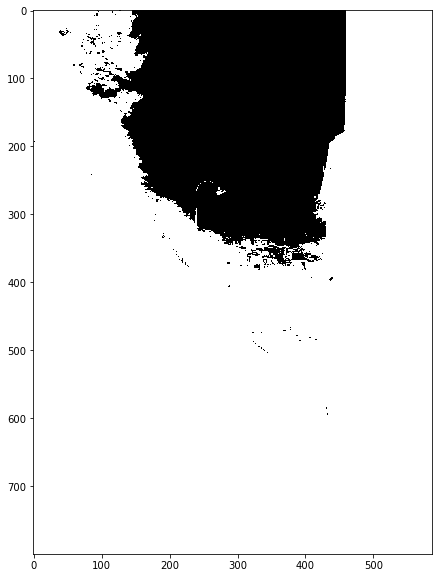

In [ ]:
img_out_otsu,tau = segmentation_otsu(img_gray)
print(tau)
display_image(img_out_otsu)
write_image(img_out_otsu,file_name+'_segmentation_otsu.png')

__Question__ What problem can you see with the segmentation result ? What morphological technique(s) (seen in the lesson) could you use to clean the result up ?


__Answer__
We can see some problems related to no geometric coherence( there are some dark points floating around white points) and a small white part in the black sky.
One solution would be using opening, closing that could reduce both these problems.

Carry out this technique to clean up the output image, and imwrite the result. You can find the necessary function(s) in the following package :

skimage.morphology

Choose the neighbourhood parameter of the functions to obtain the best results.

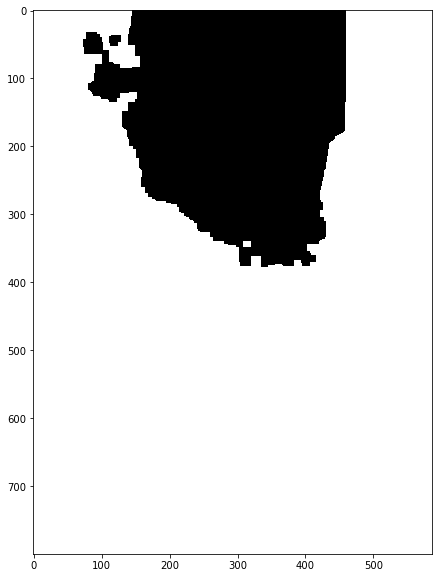

In [ ]:
from skimage.morphology import square, opening, closing

struct_size = 7
struct_el = np.ones((struct_size,struct_size))

img_out_otsu_cleaned = img_out_otsu.copy()
img_out_otsu_cleaned = opening(img_out_otsu_cleaned, square(10))
img_out_otsu_cleaned = closing(img_out_otsu_cleaned, square(10))

display_image(img_out_otsu_cleaned)
write_image(img_out_otsu_cleaned,file_name+'_segmentation_otsu_cleaned_1.png')

__Question__ In which order did you propose to carry out the morphological operations ? Why ?

__Answer__
Opening allows us to remove the black dots inside the white areas and to make the edges smoother.
Whereas closing allows us to get rid of the white floating points in the black segment of the image.

Let's change the image, and carry out the segmentation again.

C:\Users\Administrador\Anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Administrador\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Administrador\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


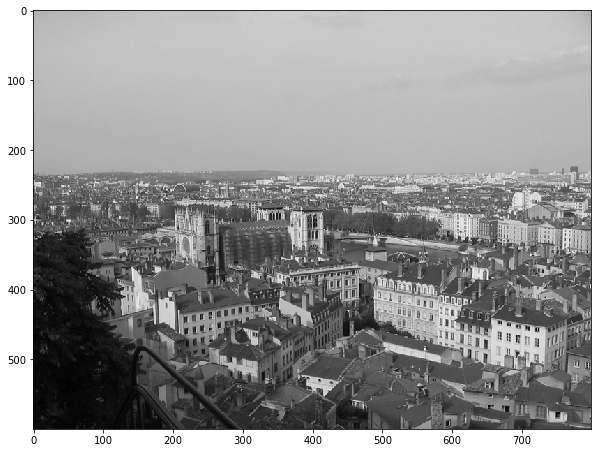

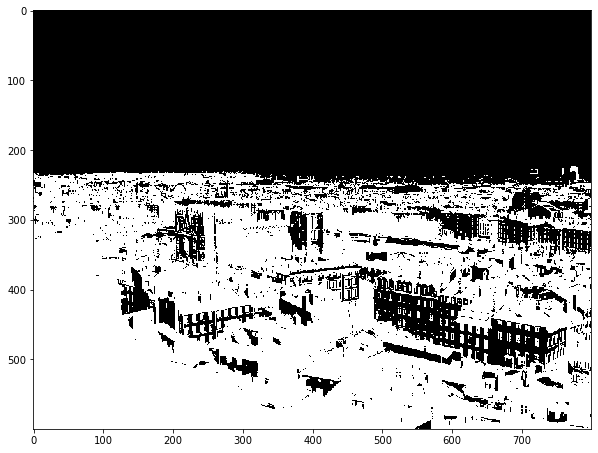

In [ ]:
file_dir = 'images/'
file_name = 'town'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/town.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)

display_image(img_gray)
img_size = img_gray.shape
img_size
img_out_otsu,tau = segmentation_otsu(img_gray)
display_image(img_out_otsu)
write_image(img_out_otsu,file_name+'_segmentation_otsu.png')

As we can see, there is no notion of connectivity in the algorithm of Otsu (two regions far away can be in the same segment). For such a notion, we turn to region merging.

## Region merging

The region merging algorithm is quite simple : we start with a small region, and add new pixels progressively to the region. More precisely, at each iteration of the algorithm, we attempt to add the neighbours of the pixels in the current segmentation. We add new pixels according to the criterion :

- $I(p)$ is added to the region if the absolute difference between the pixel value and the region's average value is less than a threshold value (which you must set).

First, create a function called ``initialize_segmentation`` which initialises the segmentation with a small circular region centred on a given seed point (the seed point is an input). For this, the following function :

- scipy.ndimage.morphology.distance_transform_edt

can be useful.

In [ ]:
from scipy.ndimage.morphology import distance_transform_edt

def initialize_segmentation(seed_pt,img_shape):
    # FILL IN CODE HERE
    dist_kernel = 10

    seg_init = np.zeros(img_shape)
    # put seed value to 1
    seg_init[seed_pt[0]][seed_pt[1]] = 1
    #Create the circle
    seg_circle = distance_transform_edt(np.logical_not(seg_init))

    seg_circle[ seg_circle < dist_kernel ] = 0
    seg_circle[ seg_circle >= dist_kernel] = 255
    seg_circle = np.abs(seg_circle - 255)
    return seg_circle

Now, create a function called ``segmentation_region_growing`` which carries out the region growing algorithm, with the criterion above, and which uses the ``initialize_segmentation`` function. Again, the functions from ``scipy.ndimage.morphology`` can be useful here.

__IMPORTANT NOTE__ Once a pixel has been added to the region, it is in the region permanently : it is not checked again in further iterations (otherwise we could remove pixels which were added).

In [ ]:
from scipy.ndimage import binary_dilation


# This function returns both the final segmentation and the initialisation
def segmentation_region_growing(img,seed_pt, tau):

    # FILL IN CODE HERE
    seg_init = initialize_segmentation(seed_pt, img.shape)
    original_seg = seg_init.copy()
    while True:

        start_seg = np.logical_not(seg_init)
        start_seg[start_seg==True] = 255
        start_seg[start_seg==False] = 0
        psi = distance_transform_edt(start_seg)
        psi[psi > 5] = 255
        psi[psi <= 5] = 0
        psi = np.logical_not(psi)

        start_seg = np.logical_not(start_seg)
        neigh = np.logical_xor(psi, start_seg)

        # Average area
        filtered_image = np.multiply(seg_init/255, img)
        average_img = filtered_image[filtered_image>0].mean()

        index_neigh = np.argwhere( neigh==True)

        # Iterate over neighors
        for index in index_neigh:
            if np.abs(img[index[0]][index[1]] - average_img) < tau:
                seg_init[index[0]][index[1]] = 255
        comparison = original_seg == seg_init
        # Check for changes in the state to stop merging
        if comparison.all():
            break
        # store new state in variable
        original_seg = seg_init.copy()

    seg_init = opening(seg_init, square(10)) # FILL IN CODE HERE
    seg_init = closing(seg_init, square(10)) # FILL IN CODE HERE

    return seg_init, original_seg

Carry out the segmentation on the input image with the seed point and threshold specified in the following code :

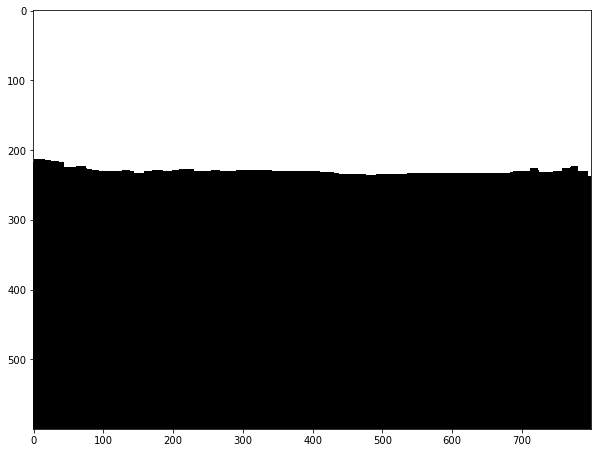

In [ ]:
seed_pt = np.asarray([130,350])
tau = 20.0 * (1.0/256.0)
img_out_region_growing,seg_init = segmentation_region_growing(img_gray,seed_pt,tau)
display_image(img_out_region_growing)
write_image(seg_init,file_name+'_segmentation_region_growing_init.png')
write_image(img_out_region_growing,file_name+'_segmentation_region_growing.png')